### <center> This notebook has the postprocess of the raw downloaded S2S forecast members and the following construction of the coastnorth/coastal hovmoller dataset

The S2S data where download for the pacific basin (110°E - 295°E, 45°S, 45°N), including variables in the "surface" category and in the "ocean category". The main difference is that the surface variables (winds and sst) are in a global 1.5°x1.5° grid, and the ocean variables (sea level, heat content, etc) are in a 1°x1° grid. Since this last grid is the finer one, the postprocess includes a regridding of the surface variables to the ocean grid, where for all variables a bilinear interpolation will be the main inteprolation method. In addition, 11 members are going to be used (1 control and 10 perturbation forecasts), so the structure of the new dataset will have the following dimensions: distance along the hovmoller (space), initialization time since 2000 to 2022, leadtime (from 0 to 46) and ensame member (from 0 to 10, being 0 the control simulation). Lets get started!


In [ ]:
# Imports
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
import multiprocessing as mp

# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

# For using more cores
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=20, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)


In [2]:
# Load masks
mask = xr.open_dataset('data/S2S_masks.nc')

In [3]:
!ls data/S2S/REFORECASTS/
print('\n')
!ls data/S2S/REFORECASTS/ensamble5 | head -n 5
print('\n')
!ls data/S2S/REFORECASTS/ensamble5/2020-01-06 | head -n 5

backup	   ensamble1   ensamble2  ensamble4  ensamble6	ensamble8  HOVMOLLERS
ensamble0  ensamble10  ensamble3  ensamble5  ensamble7	ensamble9


2020-01-06
2020-01-09
2020-01-13
2020-01-16
2020-01-20


2000-01-06_O2D.nc
2000-01-06_SURF.nc
2000-01-06_TSM.nc
2001-01-06_O2D.nc
2001-01-06_SURF.nc


As it can be seen in the previous shell command the reforecasts dataset is stored in different folders. First of all there is a folder with the ensamble member. Second there is a folder with the initialization time of each near real time (NRT) S2S forecast. Third and final are the netcdf files of the corresponding reforecast of the NRT forecast. The reforecasts are forecast initialized in the same date as a NRT S2S forecast but for the previous 20 years. Its strange but it is what it is. The dataset is saved on disk with this format because of how S2S is run (monday and thursday of every week) and because there is a chance of repeated reforecasts. 

In [14]:
def first_preprocess(ds):
    """
    This small function open an S2S netcdf file and grab the 
    46 leadtimes and define the leadtime and inittime coordinates
    """
    ds = ds.squeeze().isel(time=slice(-46,None))
    ds = ds.assign_coords({'inittime':ds.time[0].values})
    ds = ds.rename({'time':'leadtime'})
    ds.coords['leadtime'] = ('leadtime',np.arange(len(ds.leadtime)))
    return ds.compute()

def preprocess_O2D(ds):
    """
    For the ocean downloaded variables just make some clean up
    """
    ds = first_preprocess(ds)
    ds = ds.drop(['depth','depth_2','depth_2_bnds'])
    ds = ds.rename({'dslm':'zos','param18.4.10':'T300'})
    return ds

def preprocess_SURF(ds):
    """
    For downloaded winds just make some clean up
    """
    ds = first_preprocess(ds)
    ds = ds.drop(['height'])
    ds = ds[['10u','10v']]
    return ds

def load_s2s(member, date):
    """
    Given the ensamble and NRT S2S date this function
    loads all the S2S data as an xarray (ocean and winds)
    """
    dayofyear = pd.to_datetime(date).dayofyear+1
    path_surf = glob(f'data/S2S/REFORECASTS/ensamble{member}/{date}/*_SURF.nc')
    path_sst  = glob(f'data/S2S/REFORECASTS/ensamble{member}/{date}/*_TSM.nc')
    path_O2D  = glob(f'data/S2S/REFORECASTS/ensamble{member}/{date}/*_O2D.nc')
    # Load surface and ocean datasets
    surf = xr.merge([xr.open_mfdataset(path_surf, preprocess=preprocess_SURF,parallel=True, concat_dim='inittime', combine='nested'),
                    xr.open_mfdataset(path_sst, preprocess=first_preprocess,parallel=True, concat_dim='inittime', combine='nested')])
    o2d  = xr.open_mfdataset(path_O2D, preprocess=preprocess_O2D,parallel=True, concat_dim='inittime', combine='nested')
    # Perform the regridding of 1.5°x1.5° surface to 1°x1° ocean
    regridder = xe.Regridder(surf,o2d,'bilinear')
    surf      = regridder(surf.ffill('lon'))
    # Merge everything
    s2s = xr.merge([surf,o2d])
    s2s['sst'] = s2s['sst'].where(~np.isnan(s2s.zos))
    s2s  = s2s.assign_coords({'member':member}).sortby('lat').sortby('lon')
    # mask = s2s.inittime.dt.dayofyear==dayofyear # make sure that all data is for the same NRT date
    # s2s  = s2s.isel(inittime=mask)
    print(f'member{member}')
    return s2s

In [17]:
# Get the dates of the NRT S2S forecast based on the downloaded folders (this is the same as all monday and thursdays since 2000 to 2023)
dates    = sorted([x.split('/')[-1] for x in glob('data/S2S/REFORECASTS/ensamble0/*')])
members  = range(11)

tropical   = []
coastsouth = []
coastnorth = []
# Loop over dates
for it in dates[:-1]:
    # print(it,'\n')
    trop_file   = f'data/S2S/REFORECASTS/HOVMOLLERS/S2S_hovmoller_tropical_{it}.nc'
    cnorth_file = f'data/S2S/REFORECASTS/HOVMOLLERS/S2S_hovmoller_coastnorth_{it}.nc'
    csouth_file = f'data/S2S/REFORECASTS/HOVMOLLERS/S2S_hovmoller_coastsouth_{it}.nc'
    if os.path.isfile(trop_file) and os.path.isfile(cnorth_file) and os.path.isfile(csouth_file):
        trop   = xr.open_dataset(trop_file)
        cnorth = xr.open_dataset(cnorth_file)
        csouth = xr.open_dataset(csouth_file)
        
        # Check for incomplete data
        if len(trop.inittime)!=20:
            print(trop_file)
        if len(cnorth.inittime)!=20:
            print(cnorth_file)
        if len(csouth.inittime)!=20:
            print(csouth_file)
    else:
        print(it)
        # # Dont know why this isnt working so fuck it ill go with a serial loop
        # # Parallel loop over ensamble members
        # with mp.Pool(len(members)) as p:
        #     data = p.starmap(load_s2s, zip(members,[it for i in range(len(members))]))
        #     data = xr.concat(data,'member') # Data of all members in global grid
        #     # p.close()
        #     # p.join()
        
            
        # Serial loop over ensamble members
        data = []
        for m in members:
            data.append(load_s2s(m,it))
        data = xr.concat(data,'member')
        
        trop = data.sel(lat=slice(-4,4), lon=slice(mask.lon.min(), mask.lon.max()))
        trop = trop.where(mask.tropicalmask==1).mean('lat')
        trop = trop.interpolate_na('inittime').dropna('lon')
        trop.to_netcdf(trop_file, mode='w')
        
        cnorth = data.sel(lon=slice(230,295), lat=slice(0,50))
        cnorth = cnorth.ffill('lon').where(mask.coastmask_north==1).mean('lon')
        cnorth = cnorth.interpolate_na('time').dropna('lat')
        cnorth.to_netcdf(cnorth_file, mode='w')

        csouth = data.sel(lon=slice(260,295), lat=slice(-50,0))
        csouth = csouth.ffill('lon').where(mask.coastmask_south==1).mean('lon')
        csouth = csouth.interpolate_na('time').dropna('lat').sortby('lat', ascending=False)
        csouth.to_netcdf(csouth_file, mode='w')
    
    tropical.append(trop)
    coastsouth.append(csouth)
    coastnorth.append(cnorth)

In [18]:
# merge everything
tropical   = xr.concat(tropical, 'inittime').sortby('inittime')
coastnorth = xr.concat(coastnorth, 'inittime').sortby('inittime')
coastsouth = xr.concat(coastsouth, 'inittime').sortby('inittime')

Last code took a while... but now i have the hovmollers of the S2S reforecast dataset. All i need to do now is add some metadata and the new coordinates and we are good to go. First lets take a look of the new datasets...

In [28]:
tropical

<xarray.Dataset>
Dimensions:   (leadtime: 46, inittime: 7300, lon: 141, member: 11)
Coordinates:
  * leadtime  (leadtime) int64 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45
  * inittime  (inittime) datetime64[ns] 2000-01-07 2000-01-10 ... 2022-07-04
  * lon       (lon) float32 140.0 141.0 142.0 143.0 ... 277.0 278.0 279.0 280.0
  * member    (member) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    10u       (member, inittime, leadtime, lon) float32 -5.513 -5.724 ... 3.784
    10v       (member, inittime, leadtime, lon) float32 2.82 2.078 ... 3.495
    sst       (member, inittime, leadtime, lon) float32 303.3 303.3 ... 299.8
    zos       (member, inittime, leadtime, lon) float32 0.7109 0.7123 ... 0.2459
    T300      (member, inittime, leadtime, lon) float32 295.6 295.5 ... 288.6

As can be seen in the above cell, the "tropical" dataset consists of winds, sea surface temperature, sea level and ocean heat content data for 7300 forecasts, with 46 leadtimes each and 11 members. The coastsouth and coastnorth datasets look the same but following some latitudes instead of longitudes. Now i will add some metadata and save this datasets to disk for future use

In [29]:
def haversine(p1,p2):
    """
    Given two points with lat,lon coordinates, compute the distance
    between those points on the surface of the sphere with the haversine formula
    Args:
        p1 (tuple): first point lat,lon
        p2 (tuple): last point lat,lon

    Returns:
        float: distance
    """
    lat1,lon1 = p1
    lat2,lon2 = p2

    lon1,lon2,lat1,lat2 = map(np.deg2rad, [lon1,lon2,lat1,lat2])

    dlon = lon2-lon1
    dlat = lat2-lat1

    a = np.sin(dlat/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

def distances(data, lon_name='lon', lat_name='lat'):
    """
    This function uses the haversine formula to build a 
    distance vector based on the latitude and longitude
    of the hovmoller data contained in xarray format.
    Args:
        data (xarray.Dataset): 
        Data set with the coastal or coastnorth hovmoller

    Returns:
        np.array: distances in km
    """
    distance = []
    for i in range(len(data[lon_name].values)-1):
        lon1,lat1 = data[lon_name].values[i], data[lat_name].values[i]
        lon2,lat2 = data[lon_name].values[i+1], data[lat_name].values[i+1]
        dist = haversine(p1=(lat2,lon2), p2=(lat1,lon1))
        distance.append(dist)
    distance = np.hstack([np.array([0]),np.array(distance)])
    distance = np.cumsum(distance)
    return distance
    

First the new coordinates and dimensions...

In [30]:
# Find longitude of each coastal american pixel
lon,lat = np.meshgrid(mask.lon,mask.lat)
coastnorthcoords   = pd.DataFrame((lon[0,:],np.zeros(len(lon[0,:]))), index=['lon','lat']).T
lonn = []
lons = []
for i in range(len(mask.lat)):
    try:
        x = mask.coastmask_north.where(mask.coastmask_north==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lonn.append(x)
    except:
        lonn.append(np.nan)
        pass
    
    try:
        x = mask.coastmask_south.where(mask.coastmask_south==1)
        x = x.isel(lat=i).dropna('lon')[-1].lon.item()
        lons.append(x)
    except:
        lons.append(np.nan)
        pass
coastnorthcoords = pd.DataFrame((np.array(lonn),lat[:,0]),index=['lon','lat']).T.dropna()
coastsouthcoords = pd.DataFrame((np.array(lons),lat[:,0]),index=['lon','lat']).T.dropna()

coastnorthcoords.index = coastnorthcoords.lat
coastsouthcoords.index = coastsouthcoords.lat

coastnorthcoords = coastnorthcoords.loc[coastnorth.lat.values]
coastsouthcoords = coastsouthcoords.loc[coastsouth.lat.values]

In [32]:
# Assign the position along lons as a new spatial dimension/coordinate
tropical = tropical.assign_coords({'index':('lon',range(len(tropical.lon)))})
tropical = tropical.swap_dims({'lon':'index'}) # Make the position in the grid as the main coordinate
tropical = tropical.assign_coords({'lat':('index', np.zeros(len(tropical.index)))}) # Add latitudes

# Same but for coastnorth array
coastnorth = coastnorth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastnorth.lat)))}) # Add the position coordinate as the continuity of the coastnorth one
coastnorth = coastnorth.swap_dims({'lat':'index'})
coastnorth = coastnorth.assign_coords({'lon':('index', coastnorthcoords.lon.values)})

# Same but for coastsouth array
coastsouth = coastsouth.assign_coords({'index':('lat', 1+tropical.index[-1].item()+np.arange(len(coastsouth.lat)))}) # idem
coastsouth = coastsouth.swap_dims({'lat':'index'})
coastsouth = coastsouth.assign_coords({'lon':('index', coastsouthcoords.lon.values)})

In [37]:
# Assign distance as new coordinate for the tropical hovmoller
tropical = tropical.assign_coords({'distance':('index',distances(tropical))})
tropical = tropical.swap_dims({'index':'distance'})
tropical = tropical[['member','inittime','leadtime','distance','lat','lon','index','10u','10v','sst','zos','T300']]

# Assign distance as new coordinate for the coastnorth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastnorth.lat[0].item(),coastnorth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastnorth = coastnorth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastnorth))})
coastnorth = coastnorth.swap_dims({'index':'distance'})
coastnorth = coastnorth[['member','inittime','leadtime','distance','lat','lon','index','10u','10v','sst','zos','T300']]

# Assign distance as new coordinate for the coastsouth hovmoller
gap = haversine((tropical.lat[-1].item(),tropical.lon[-1].item()),(coastsouth.lat[0].item(),coastsouth.lon[0].item())) # Distance between last pixel of coastnorth hovmoller and fisrst of coastnorth hovmoller
coastsouth = coastsouth.assign_coords({'distance':('index',tropical.distance[-1].item()+gap+distances(coastsouth))})
coastsouth = coastsouth.swap_dims({'index':'distance'})
coastsouth = coastsouth[['member','inittime','leadtime','distance','lat','lon','index','10u','10v','sst','zos','T300']]

In [67]:
# Change some units
tropical['sst']   = tropical['sst']-273.15
coastnorth['sst'] = coastnorth['sst']-273.15
coastsouth['sst'] = coastsouth['sst']-273.15

tropical['T300']   = tropical['T300']-273.15
coastnorth['T300'] = coastnorth['T300']-273.15
coastsouth['T300'] = coastsouth['T300']-273.15

Now the metadata...

In [69]:
dummy_surf = xr.open_dataset('data/S2S/REFORECASTS/ensamble0/2020-01-06/2000-01-06_SURF.nc') # dummy dataset with some attributes
dummy_o2d = xr.open_dataset('data/S2S/REFORECASTS/ensamble0/2020-01-06/2000-01-06_O2D.nc') # dummy dataset with some attributes
dummy_sst = xr.open_dataset('data/S2S/REFORECASTS/ensamble0/2020-01-06/2000-01-06_TSM.nc') # dummy dataset with some attributes

# Global attributes
tropical_attrs   = {'name':'Tropical Hovmoller of S2S reforecasts',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'S2S average along the tropical band (2°S - 2°N)',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastnorth_attrs = {'name':'Coastal Hovmoller of S2S reforecasts for the North East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'S2S average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}
coastsouth_attrs = {'name':'Coastal Hovmoller of S2S reforecasts for the South East Pacific',
                    'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
                    'description':'S2S average along a coastal band of 1deg latitude',
                    'author':'Lucas Glasner',
                    'contact':'lucas.glasner@ceaza.cl'}

# Common variable attributes
u10_attrs        = dummy_surf['10u'].attrs
v10_attrs        = dummy_surf['10v'].attrs
zos_attrs        = dummy_o2d['dslm'].attrs
T300_attrs       = {'long_name':'Ocean Heat Content defined as the mean temperature of the first 300 meters',
                    'short_name':'T300',
                    'units':'degC'}
sst_attrs        = dummy_sst.sst.attrs
sst_attrs['units'] = 'degC'
lon_attrs        = dummy_o2d.lon.attrs
lat_attrs        = dummy_o2d.lat.attrs
leadtime_attrs   = {'long_name':'Days since forecast initialization',
                    'short_name':'Lead time',
                    'units':'days'}
inittime_attrs   = {'long_name':'Time of forecast initialization',
                    'short_name':'Initialization time',
                    'axis':'T'}
index_attrs      = {'long_name':'Position along the spatial dimension of the hovmoller grid',
                    'short_name':'index',
                    'units':'(-)'}
distance_attrs   = {'long_name':'Distance along the spatial dimension of the hovmoller grid',
                    'short_name':'distance',
                    'units':'km'}
member_attrs     = {'long_name':'Ensamble member number',
                    'short_name':'Member'}

In [71]:
# Assign attributes 
tropical.attrs          = tropical_attrs
tropical['10v'].attrs   = v10_attrs
tropical['10u'].attrs   = u10_attrs
tropical.zos.attrs      = zos_attrs
tropical.sst.attrs      = sst_attrs
tropical.T300.attrs     = T300_attrs
tropical.lon.attrs      = lon_attrs
tropical.lat.attrs      = lat_attrs
tropical.index.attrs    = index_attrs
tropical.distance.attrs = distance_attrs
tropical.inittime.attrs = inittime_attrs
tropical.leadtime.attrs = leadtime_attrs
tropical.member.attrs   = member_attrs

coastnorth.attrs          = coastnorth_attrs
coastnorth['10v'].attrs   = v10_attrs
coastnorth['10u'].attrs   = u10_attrs
coastnorth.zos.attrs      = zos_attrs
coastnorth.sst.attrs      = sst_attrs
coastnorth.T300.attrs     = T300_attrs
coastnorth.lon.attrs      = lon_attrs
coastnorth.lat.attrs      = lat_attrs
coastnorth.index.attrs    = index_attrs
coastnorth.distance.attrs = distance_attrs
coastnorth.inittime.attrs = inittime_attrs
coastnorth.leadtime.attrs = leadtime_attrs
coastnorth.member.attrs   = member_attrs

coastsouth.attrs          = coastsouth_attrs
coastsouth['10v'].attrs   = v10_attrs
coastsouth['10u'].attrs   = u10_attrs
coastsouth.zos.attrs      = zos_attrs
coastsouth.sst.attrs      = sst_attrs
coastsouth.T300.attrs     = T300_attrs
coastsouth.lon.attrs      = lon_attrs
coastsouth.lat.attrs      = lat_attrs
coastsouth.index.attrs    = index_attrs
coastsouth.distance.attrs = distance_attrs
coastsouth.inittime.attrs = inittime_attrs
coastsouth.leadtime.attrs = leadtime_attrs
coastsouth.member.attrs   = member_attrs

Now some last checkout plots...

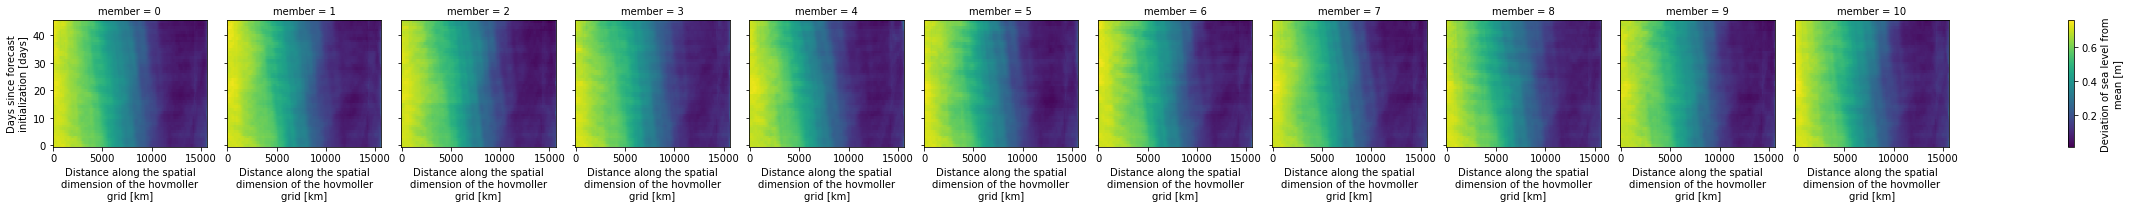

In [76]:
tropical.zos[:,0,:,:].plot(col='member')

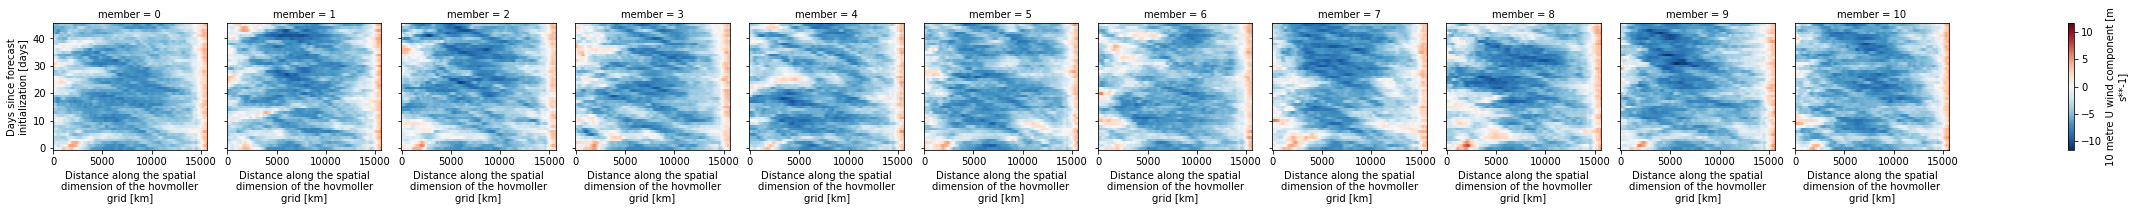

In [80]:
tropical['10u'][:,178,:,:].plot(col='member')

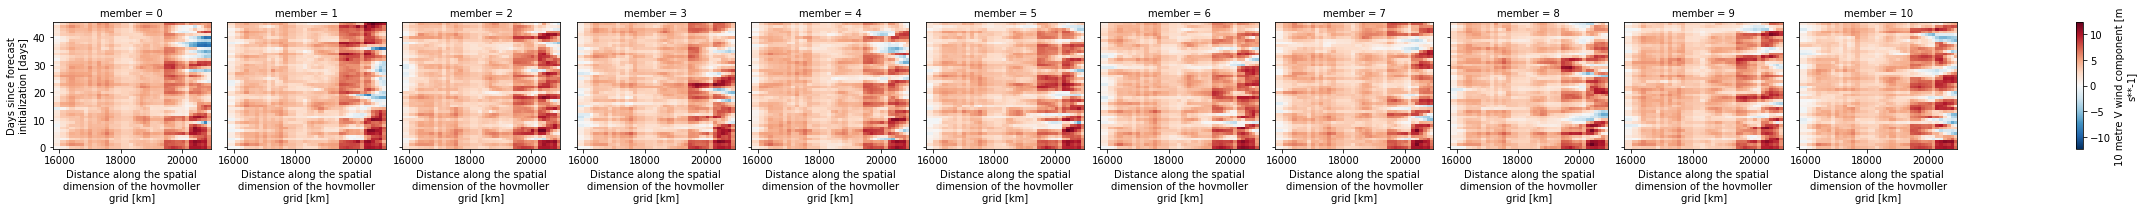

In [81]:
coastsouth['10v'][:,2854,:,:].plot(col='member')

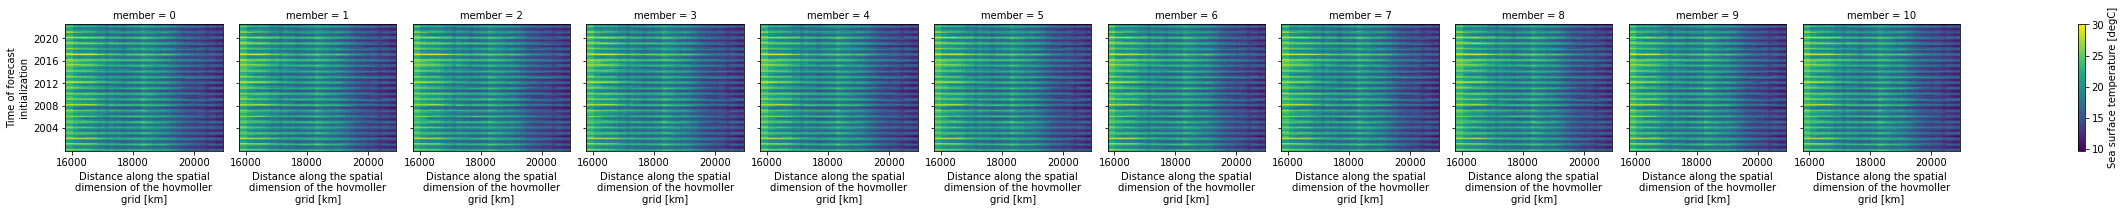

In [82]:
coastsouth['sst'][:,:,5,:].plot(col='member')

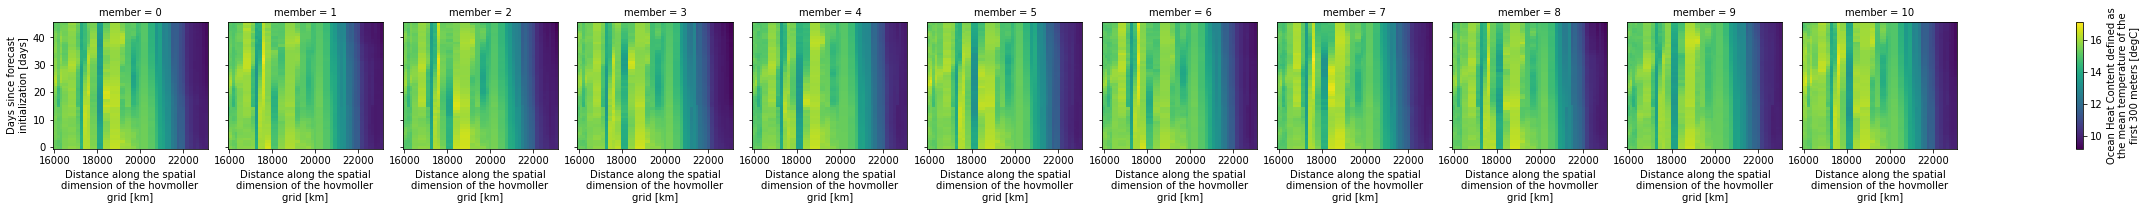

In [83]:
coastnorth['T300'][:,6498,:,:].plot(col='member')

In [86]:
# Save data into disk
tropical.to_netcdf('./data/HOVMOLLERS/S2S_hovmoller_tropical_2000-2022.nc')
coastnorth.to_netcdf('./data/HOVMOLLERS/S2S_hovmoller_coastnorth_2000-2022.nc')
coastsouth.to_netcdf('./data/HOVMOLLERS/S2S_hovmoller_coastsouth_2000-2022.nc')

In [ ]:
client.shutdown()